<a href="https://colab.research.google.com/github/martenzZe/Evaluating-Telemarketing-Strategies-in-Digital-Banking/blob/main/M4RAI_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy
!pip install lime
!pip install shap

# from sklearn.model_selection import StratifiedKFold # unused
from sklearn.preprocessing import StandardScaler
from scipy import stats as sts
import pandas as pd
from scipy.stats.distributions import randint
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
import lime as lime
from lime.lime_tabular import LimeTabularExplainer
import shap as shap
import pickle
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Importing the datafile (**Must Run**)

In [ ]:
# Importing the datafile as df
df = pd.read_csv('bank-full.csv',sep=";")
df.head(2)
print(df)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd

##**2) Data Exploration & Descriptive Statistics**

In [ ]:
#printing the column names, 5 rows of the head and the distribution of the set
print("Columns:\n", df.columns)
print("\nFirst 5 Rows:\n", df.head())
print("\nShape of Data Set:\n", df.shape)

Columns:
 Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

First 5 Rows:
    age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may

3) **Descriptive Statistics**

In [ ]:
#printing descriptive statistics of the total dataset, the distribution of age and job
print("\nSummary:\n", df.describe())
print("\nAge:\n", df["age"].value_counts())
print("\nJob:\n", df["job"].value_counts())


Summary:
                 age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000

4) **Visual Exploratory Data Analysis**

4.1) **Histogram & Boxplot: Age**

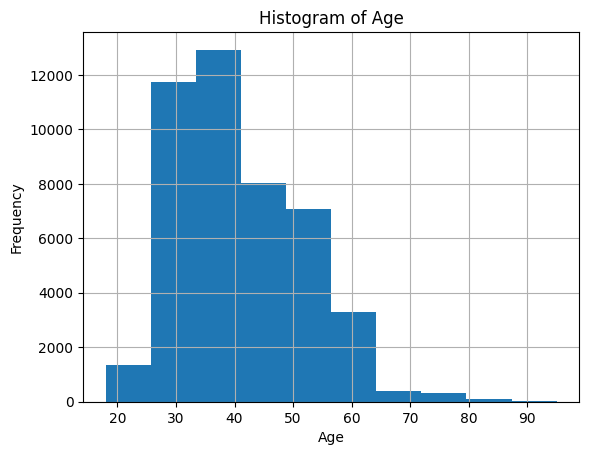

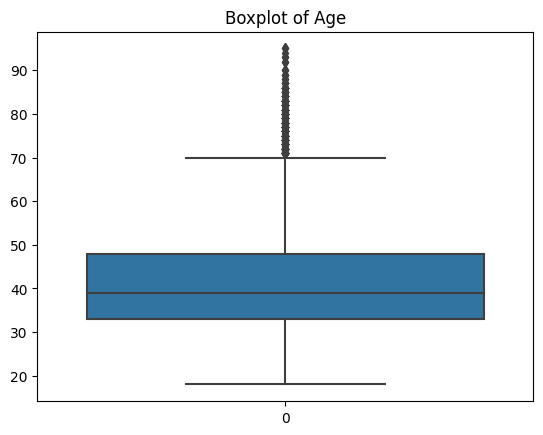

In [ ]:
# 4.1 Histogram & Boxplot: Age
df['age'].hist()
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

sns.boxplot(df['age'])
plt.title("Boxplot of Age")
plt.show()

4.2) **Histogram: Educational Level**

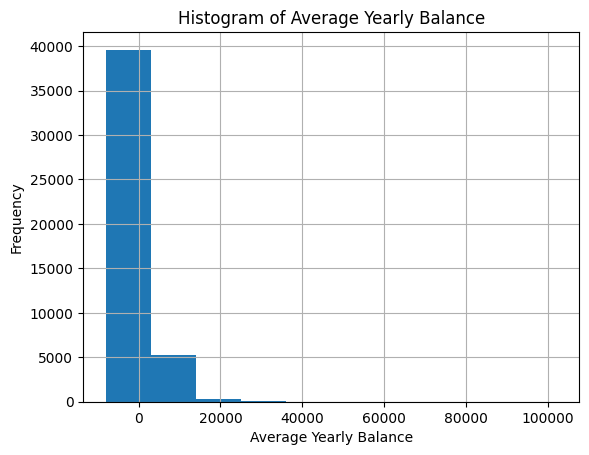

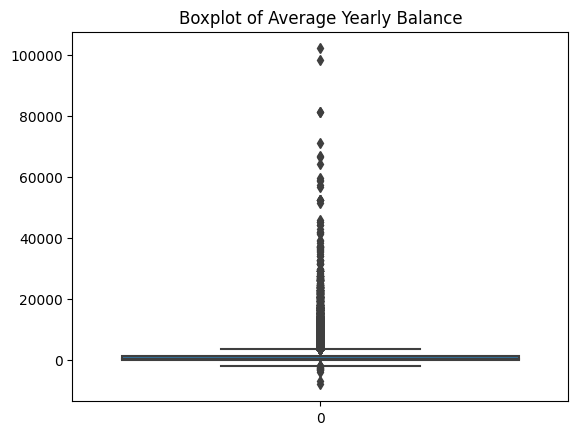

In [ ]:
#histogram of the yearly balance and boxplot of the histogram
df['balance'].hist()
plt.title("Histogram of Average Yearly Balance")
plt.xlabel("Average Yearly Balance")
plt.ylabel("Frequency")
plt.show()

sns.boxplot(df['balance'])
plt.title("Boxplot of Average Yearly Balance")
plt.show()

5) **Correlation Analysis**

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


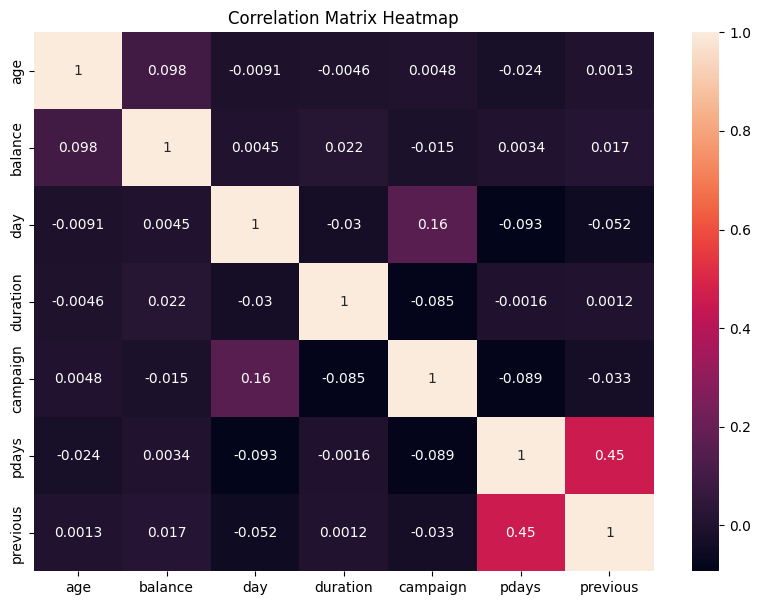

In [ ]:
#Correlation matrix to see perhaps existing correlations between categories
corr_matrix = df.corr()
plt.figure(figsize = (10,7))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

6) **Advanced Exploratory Data Analysis**

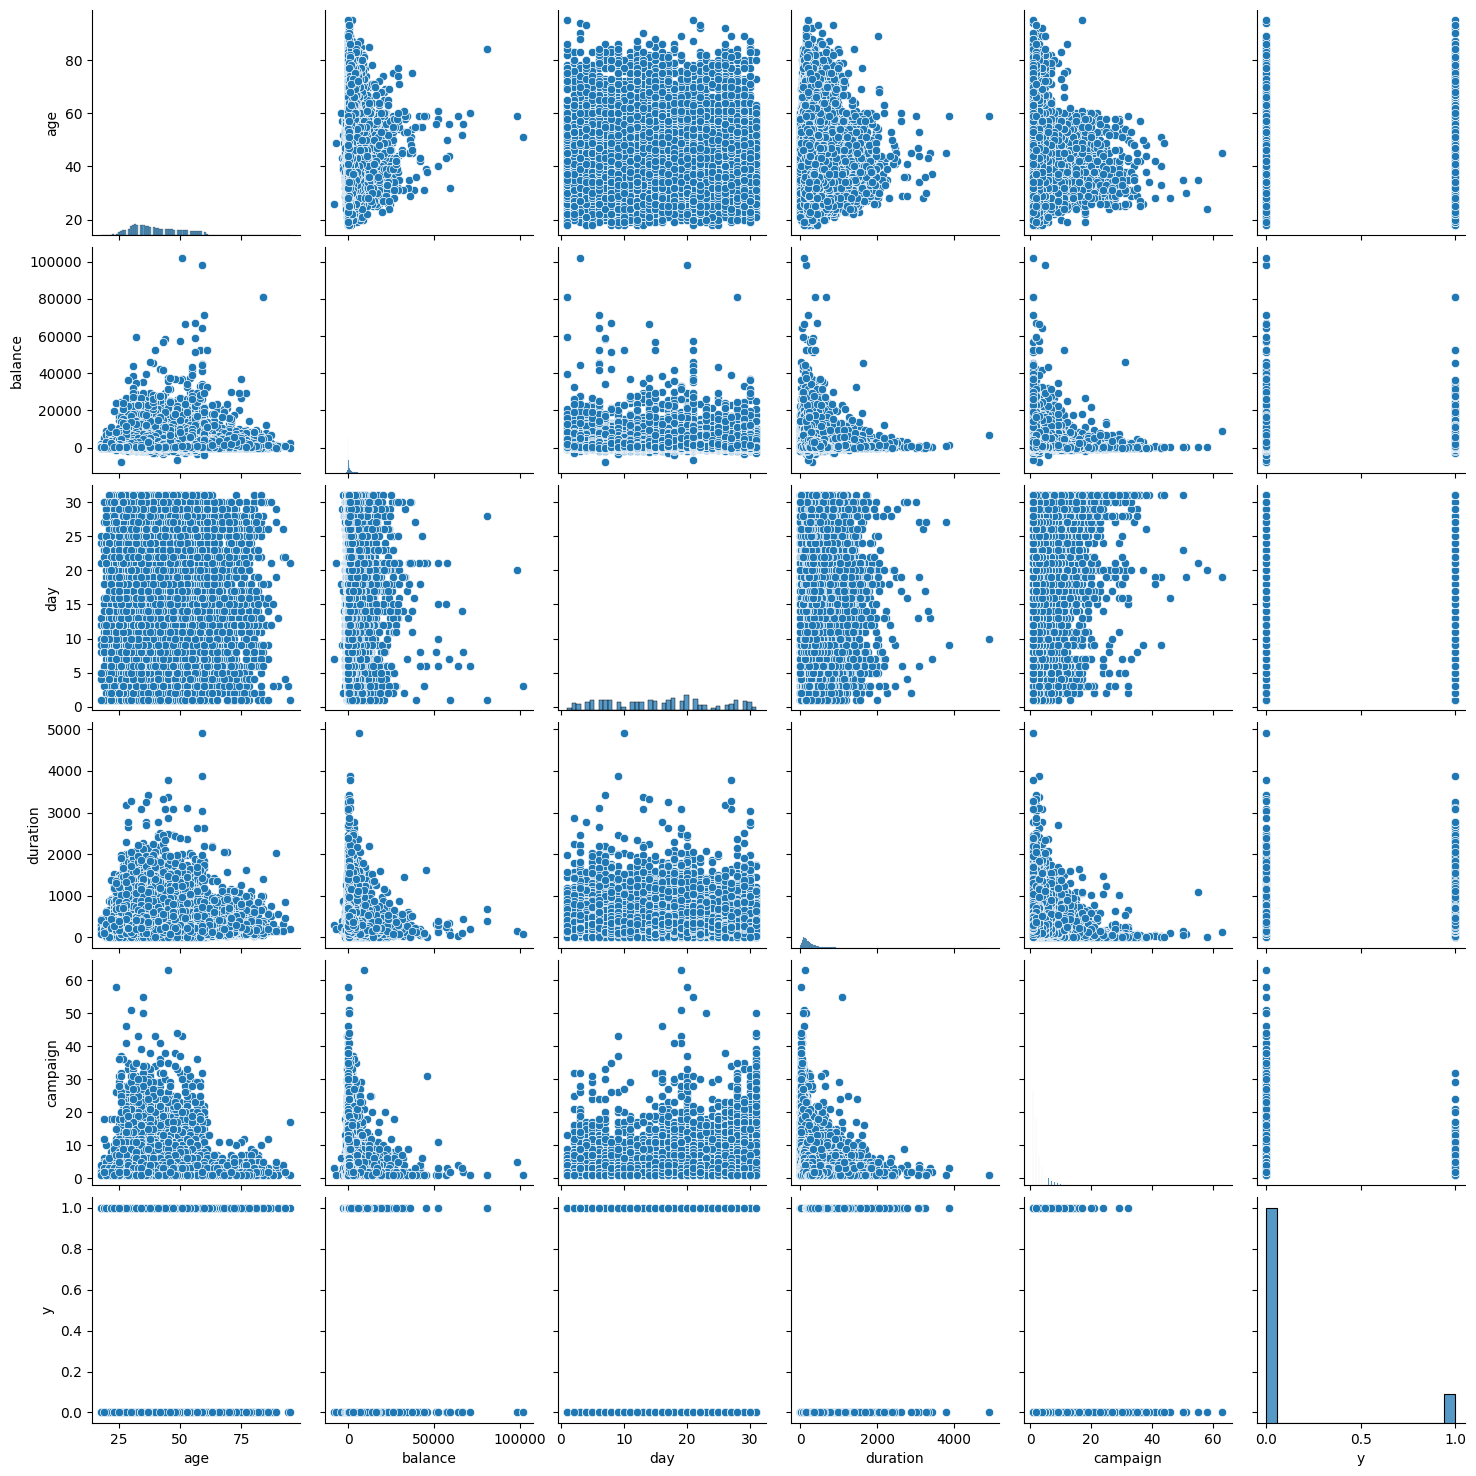

In [ ]:
sns.pairplot(df[['age', 'balance', 'day', 'duration','campaign', 'y']])
plt.show()

##**One Hot Encoding**

In [ ]:
data = pd.read_csv('bank-full.csv', delimiter=';') #load the file again

#split the balance into binned version of the categories to reduce overfitting
data['balance_binned'] = pd.cut(data['balance'], bins=[-np.inf, 0, 1000, np.inf], labels=['Low', 'Medium', 'High'])
data['age_binned'] = pd.cut(data['age'], bins =[18, 25, 35 ,55, 120], labels = ['18,25', '25,35', '35,55', '55+'])
#drop data categories that are irrelevant for model training
#
#here we drop balance and age so they can be properly replaced by the binned versions
data.drop('balance', axis=1, inplace=True)
data.drop('age', axis = 1, inplace = True)

#We are looking for socioeconomic variables. Everything else can be deleted
data.drop('contact', axis =1, inplace=True)
data.drop('day', axis =1, inplace=True)
data.drop('month', axis =1, inplace = True)
data.drop('pdays', axis = 1, inplace = True)
data.drop('campaign', axis =1, inplace = True)
data.drop('default', axis = 1, inplace = True)
data.drop('previous', axis = 1, inplace = True)
data.drop('poutcome', axis = 1, inplace = True)

#Reason to drop duration is the assumption that a longer call meant that the person subscribed,
#so future calls cannot be based on this
data.drop('duration', axis = 1, inplace = True)



#pd.get_dummies encodes all categories
data_encoded = pd.get_dummies(data, columns=[
    'marital', 'education','housing', 'loan', 'balance_binned', 'job','y', 'age_binned'])

#show head of data to check values and encoding
data_encoded.head(5)


marital_divorced  marital_married  marital_single  education_primary  \
0                 0                1               0                  0   
1                 0                0               1                  0   
2                 0                1               0                  0   
3                 0                1               0                  0   
4                 0                0               1                  0   

   education_secondary  education_tertiary  education_unknown  housing_no  \
0                    0                   1                  0           0   
1                    1                   0                  0           0   
2                    1                   0                  0           0   
3                    0                   0                  1           0   
4                    0                   0                  1           1   

   housing_yes  loan_no  ...  job_student  job_technician  job_unemployed  \
0            1        1  ...            0               0               0   
1            1        1  ...            0               1               0   
2            1        0  ...            0               0               0   
3            1        1  ...            0               0               0   
4            0        1  ...            0               0               0   

   job_unknown  y_no  y_yes  age_binned_18,25  age_binned_25,35  \
0            0     1      0                 0                 0   
1            0     1      0                 0                 0   
2            0     1      0                 0                 1   
3            0     1      0                 0                 0   
4            1     1      0                 0                 1   

   age_binned_35,55  age_binned_55+  
0                 0               1  
1                 1               0  
2                 0               0  
3                 1               0  
4                 0               0  

[5 rows x 32 columns]

##**Training Models** (Logistic regression, HighGradientBoosterClassifier, K-Nearest-Neigbour, Random Forest

##**Logistic Regression**

The logistic regression gave us a good accuracy, but a terrible precision and recall. We decided to not base our conclusion on this model

In [ ]:
import pandas as pd
data = pd.read_csv("bank-full.csv", delimiter = ";")
data_encoded = data_encoded

#split the data into: categories and yes and no
X_1 = data_encoded.drop(["y_yes", "y_no"], axis=1)
y_1 = data_encoded["y_yes"]
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.20, random_state=0)

#scale the sets to balance the dataset
scaledsets = StandardScaler()
X_1_train_scaled = scaledsets.fit_transform(X_1_train)
X_1_test_scaled = scaledsets.transform(X_1_test)

logistic_regression = LogisticRegression(solver='saga', max_iter=1999)  #iterations needed is >1000 <2000
logistic_regression.fit(X_1_train_scaled, y_1_train)

parametric_grid = {
    'C': [0.01],
    'penalty': ['l1'],
    'solver': ['saga']
}
#we will use gridsearchcv to find our best parametrics through multi-fold testing of parameter combinations
grid_search = GridSearchCV(LogisticRegression(max_iter=1999), parametric_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_1_train_scaled, y_1_train)
print("Best Parameters found: ", grid_search.best_params_)

best_lr = grid_search.best_estimator_
y_1_pred = best_lr.predict(X_1_test_scaled)

accuracy = accuracy_score(y_1_test, y_1_pred)
print(f'Logistic Regression accuracy with best parameters: {accuracy}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters found:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression accuracy with best parameters: 0.8824505142098861


##**HistogramGradientBoosterClassifier**

Once again the Accuracy was well, but the precision and recall were low. Also we concluded that because of the amount of variables and the analysis we will do later, this model is not fit.

In [ ]:
# Assuming 'data_encoded' is already defined and preprocessed
X_2 = data_encoded.drop(['y_yes', 'y_no'], axis=1)
y_2 = data_encoded['y_yes']

# Best parameters for HGBC
best_params = {
    'min_samples_leaf': 20,
    'max_iter': 100,
    'max_depth': 5,
    'max_bins': 255,
    'learning_rate': 0.001,
    'l2_regularization': 1
}

best_HGBC = HistGradientBoostingClassifier(**best_params)

# 3-fold cross-validation
cv_scores = cross_val_score(best_HGBC, X_2, y_2)

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

# You can still train the model on the entire dataset and save it
best_HGBC.fit(X_2, y_2)
filename = 'arschan_sav'
pickle.dump(best_HGBC, open(filename, 'wb'))


KeyboardInterrupt: ignored

##Random Forest + SMOTE


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# Assuming you have already loaded your data and encoded it as 'data_encoded'

# Split the data into features (X_4) and target (y_4)
X_4 = data_encoded.drop(['y_yes', 'y_no'], axis=1)
y_4 = data_encoded['y_yes']

# Here we split the dataset into a 80/20 distribution (20 being the training set)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.20, random_state=200)

# Here RandomOverSampler has been used to counter the class distribution
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_4_train_resampled, y_4_train_resampled = ros.fit_resample(X_4_train, y_4_train)

param_grid = {
    'n_estimators': [200, 300],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt'],
    'max_depth': [200]
}

# Performing grid search using the resampled data to find the best model
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_4_train_resampled, y_4_train_resampled)
best_rf_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_rf_model.predict(X_4_test)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_4_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6482362047992922


##Decision Tree

What we try to achieve here, is to find a moment where the accuracy is acceptable, recall around 60% and precision a little low. This way the model will give us more false positives, and we can by analysis find how to model behaves in LIME analysis. Here we can also see which parameters are most important in qualifying a customer.

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

X_3 = data_encoded.drop(['y_yes', 'y_no'], axis=1)
y_3 = data_encoded['y_yes']

# Split the data into training and testing sets (80% train, 20% test)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.20, random_state=200)

# Create a Decision Tree classifier with adjusted hyperparameters
decision_tree = DecisionTreeClassifier(
    random_state=1,
    max_depth=100,            # Increase depth for a deeper tree
    min_samples_split=10,       # Increase for more splits
    min_samples_leaf=2,        # Increase for more leaf nodes
    max_leaf_nodes=230000000,   # Increase for more leaf nodes
    max_features=1000000000000000,  # Set to None to consider all features
    criterion='log_loss',          # Criterion for quality of split
    min_weight_fraction_leaf=0.001,  # Minimum weighted fraction of samples required in a leaf
    min_impurity_decrease=0.000001,     # Minimum impurity decrease required for a split
    class_weight='balanced',             # Set to 'balanced' for balanced class weights
    splitter='best'                # Strategy to choose the split at each node ('best' or 'random')
)

# Train the model on the training data
decision_tree.fit(X_3_train, y_3_train)

# Make predictions on the test data
y_pred = decision_tree.predict(X_3_test)

# Calculate and print evaluation metrics
precision = precision_score(y_3_test, y_pred)
recall = recall_score(y_3_test, y_pred)
accuracy = accuracy_score(y_3_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

Precision: 0.1963226571767497
Recall: 0.6204311152764761
Accuracy: 0.6555346676987726


##**Confusion Matrices to Evaluate Outcomes**

##HGBC Confusion Matrix

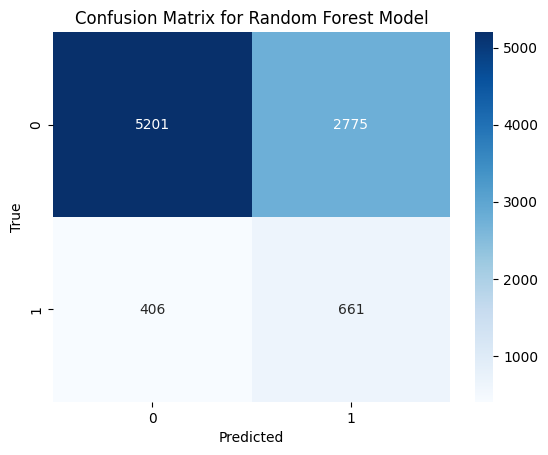

Precision: 0.19
Recall: 0.62
F1-Score: 0.29


In [ ]:
cm = confusion_matrix(y_4_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

TP = 657
FP = 2759
FN = 410
TN = 5217

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)
 j

##Decision Tree Confusion Matrix

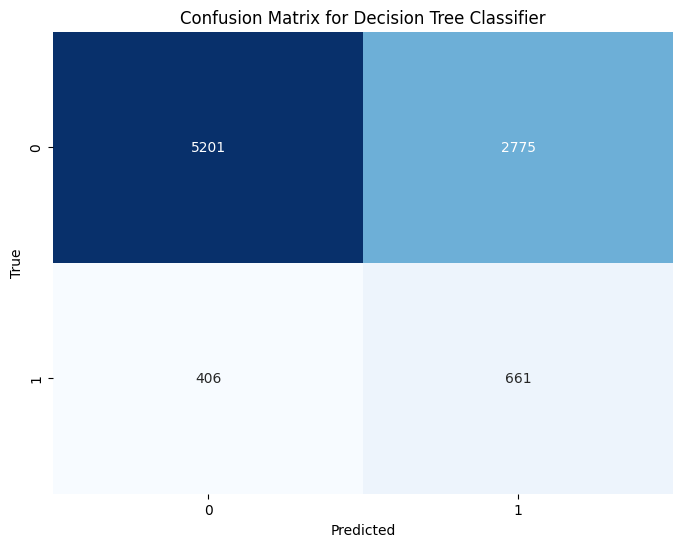

In [ ]:
cm = confusion_matrix(y_3_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

##Lime Analysis of Random Forest

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_3_train.values,
                                                   feature_names=X_3_train.columns,
                                                   class_names=["Not Subscribe", "Subscribe"],
                                                   mode='classification')


i = 0
exp = explainer.explain_instance(X_3_test.values[i], best_rf_model.predict_proba)


##Lime Analysis of Decision Tree

In [ ]:
# Create a LIME explainer
explainer = LimeTabularExplainer(X_3_train.values,
                                                   feature_names=X_3_train.columns,
                                                   class_names=["Not Subscribe", "Subscribe"],
                                                   mode='classification')

# Choose an instance to explain (e.g., the first instance from the test set)
instance_to_explain = X_3_test.iloc[0]

# Explain the instance's prediction
explanation = explainer.explain_instance(instance_to_explain, decision_tree.predict_proba)

# Display the explanation as text
explanation.show_in_notebook()


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_3_train.values,
                                                   feature_names=X_3_train.columns,
                                                   class_names=["Not Subscribe", "Subscribe"],
                                                   mode='classification')


i = 3
exp = explainer.explain_instance(X_4_test.values[i], best_rf_model.predict_proba)

exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Feature Importance:
housing_yes <= 0.00: 0.14535859424698974
loan_yes <= 0.00: 0.11096032710051267
0.00 < age_binned_35,55 <= 1.00: -0.07333507379969698
education_primary <= 0.00: 0.06997514279908032
balance_binned_Low <= 0.00: 0.05311644849725212
0.00 < marital_married <= 1.00: -0.04986300779701215
education_tertiary <= 0.00: -0.04524229964059259
0.00 < balance_binned_High <= 1.00: 0.03750060289236369
age_binned_18,25 <= 0.00: -0.03731444389775216
job_retired <= 0.00: -0.020133692405676855


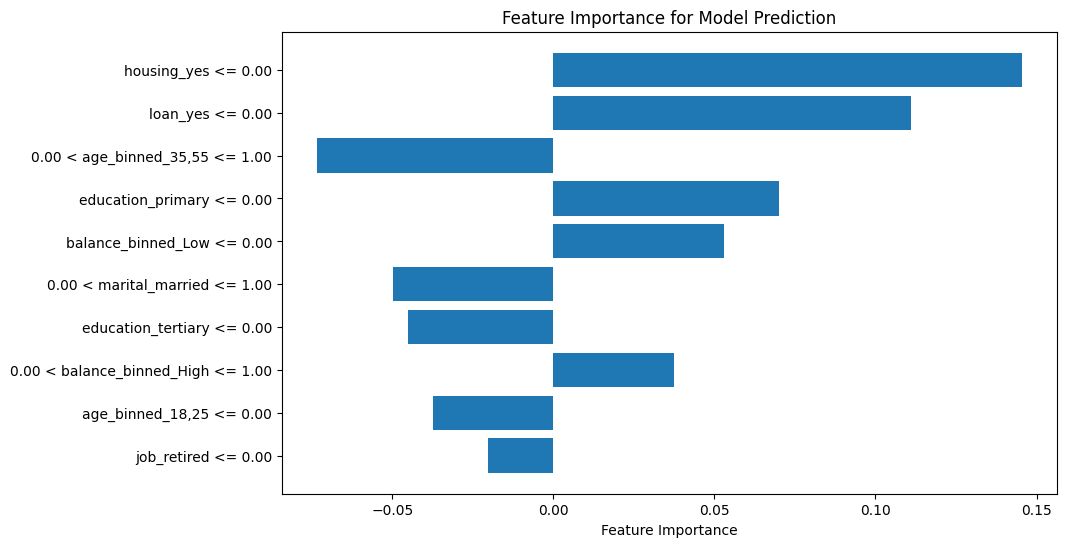

In [ ]:
feature_importance = explanation.as_list()

# Display the feature importance
print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")
feature_importance = explanation.as_list()
import matplotlib.pyplot as plt

# Get the feature importance from the LIME explanation
feature_importance = explanation.as_list()

# Separate feature names and importance values
features, importance_values = zip(*feature_importance)

# Create a bar chart to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importance_values)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Model Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top

# Manually set y-axis ticks and labels
plt.yticks(range(len(features)), features)

plt.show()


##SHAP Analysis of Decision Treee

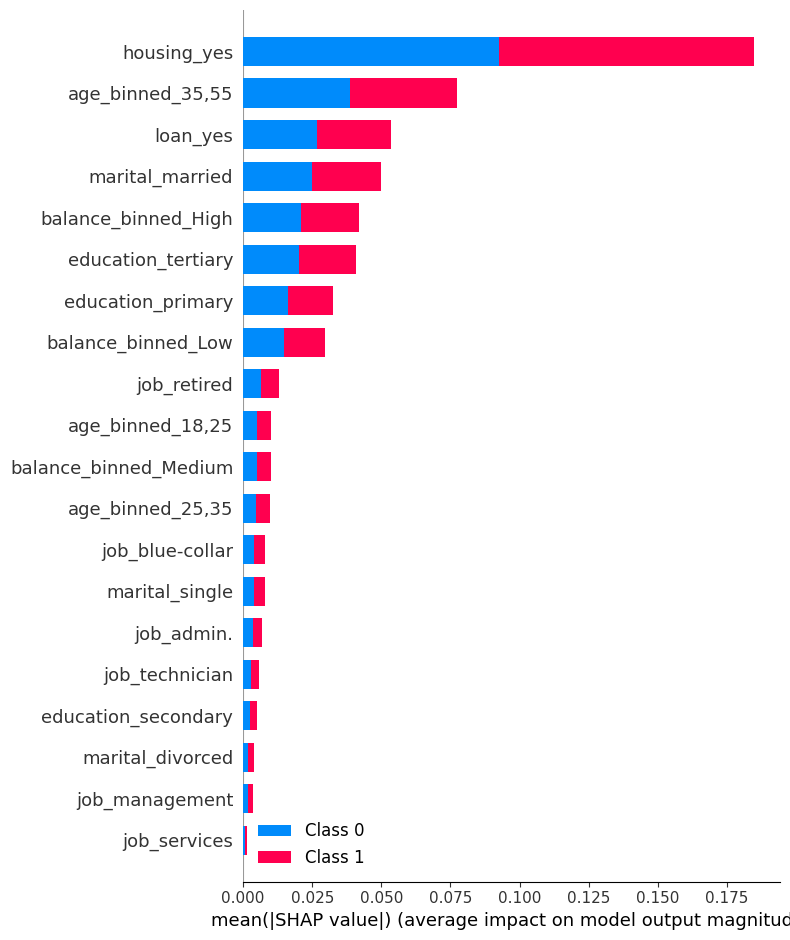

In [ ]:
feature_names = X_3.columns.tolist()

# Create a SHAP explainer for your trained model
explainer = shap.Explainer(decision_tree)

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_3_test)

# Generate SHAP summary plots with feature names
shap.summary_plot(shap_values, X_3_test.values, feature_names=feature_names)

##Decision Tree visualisation

ValueError: ignored

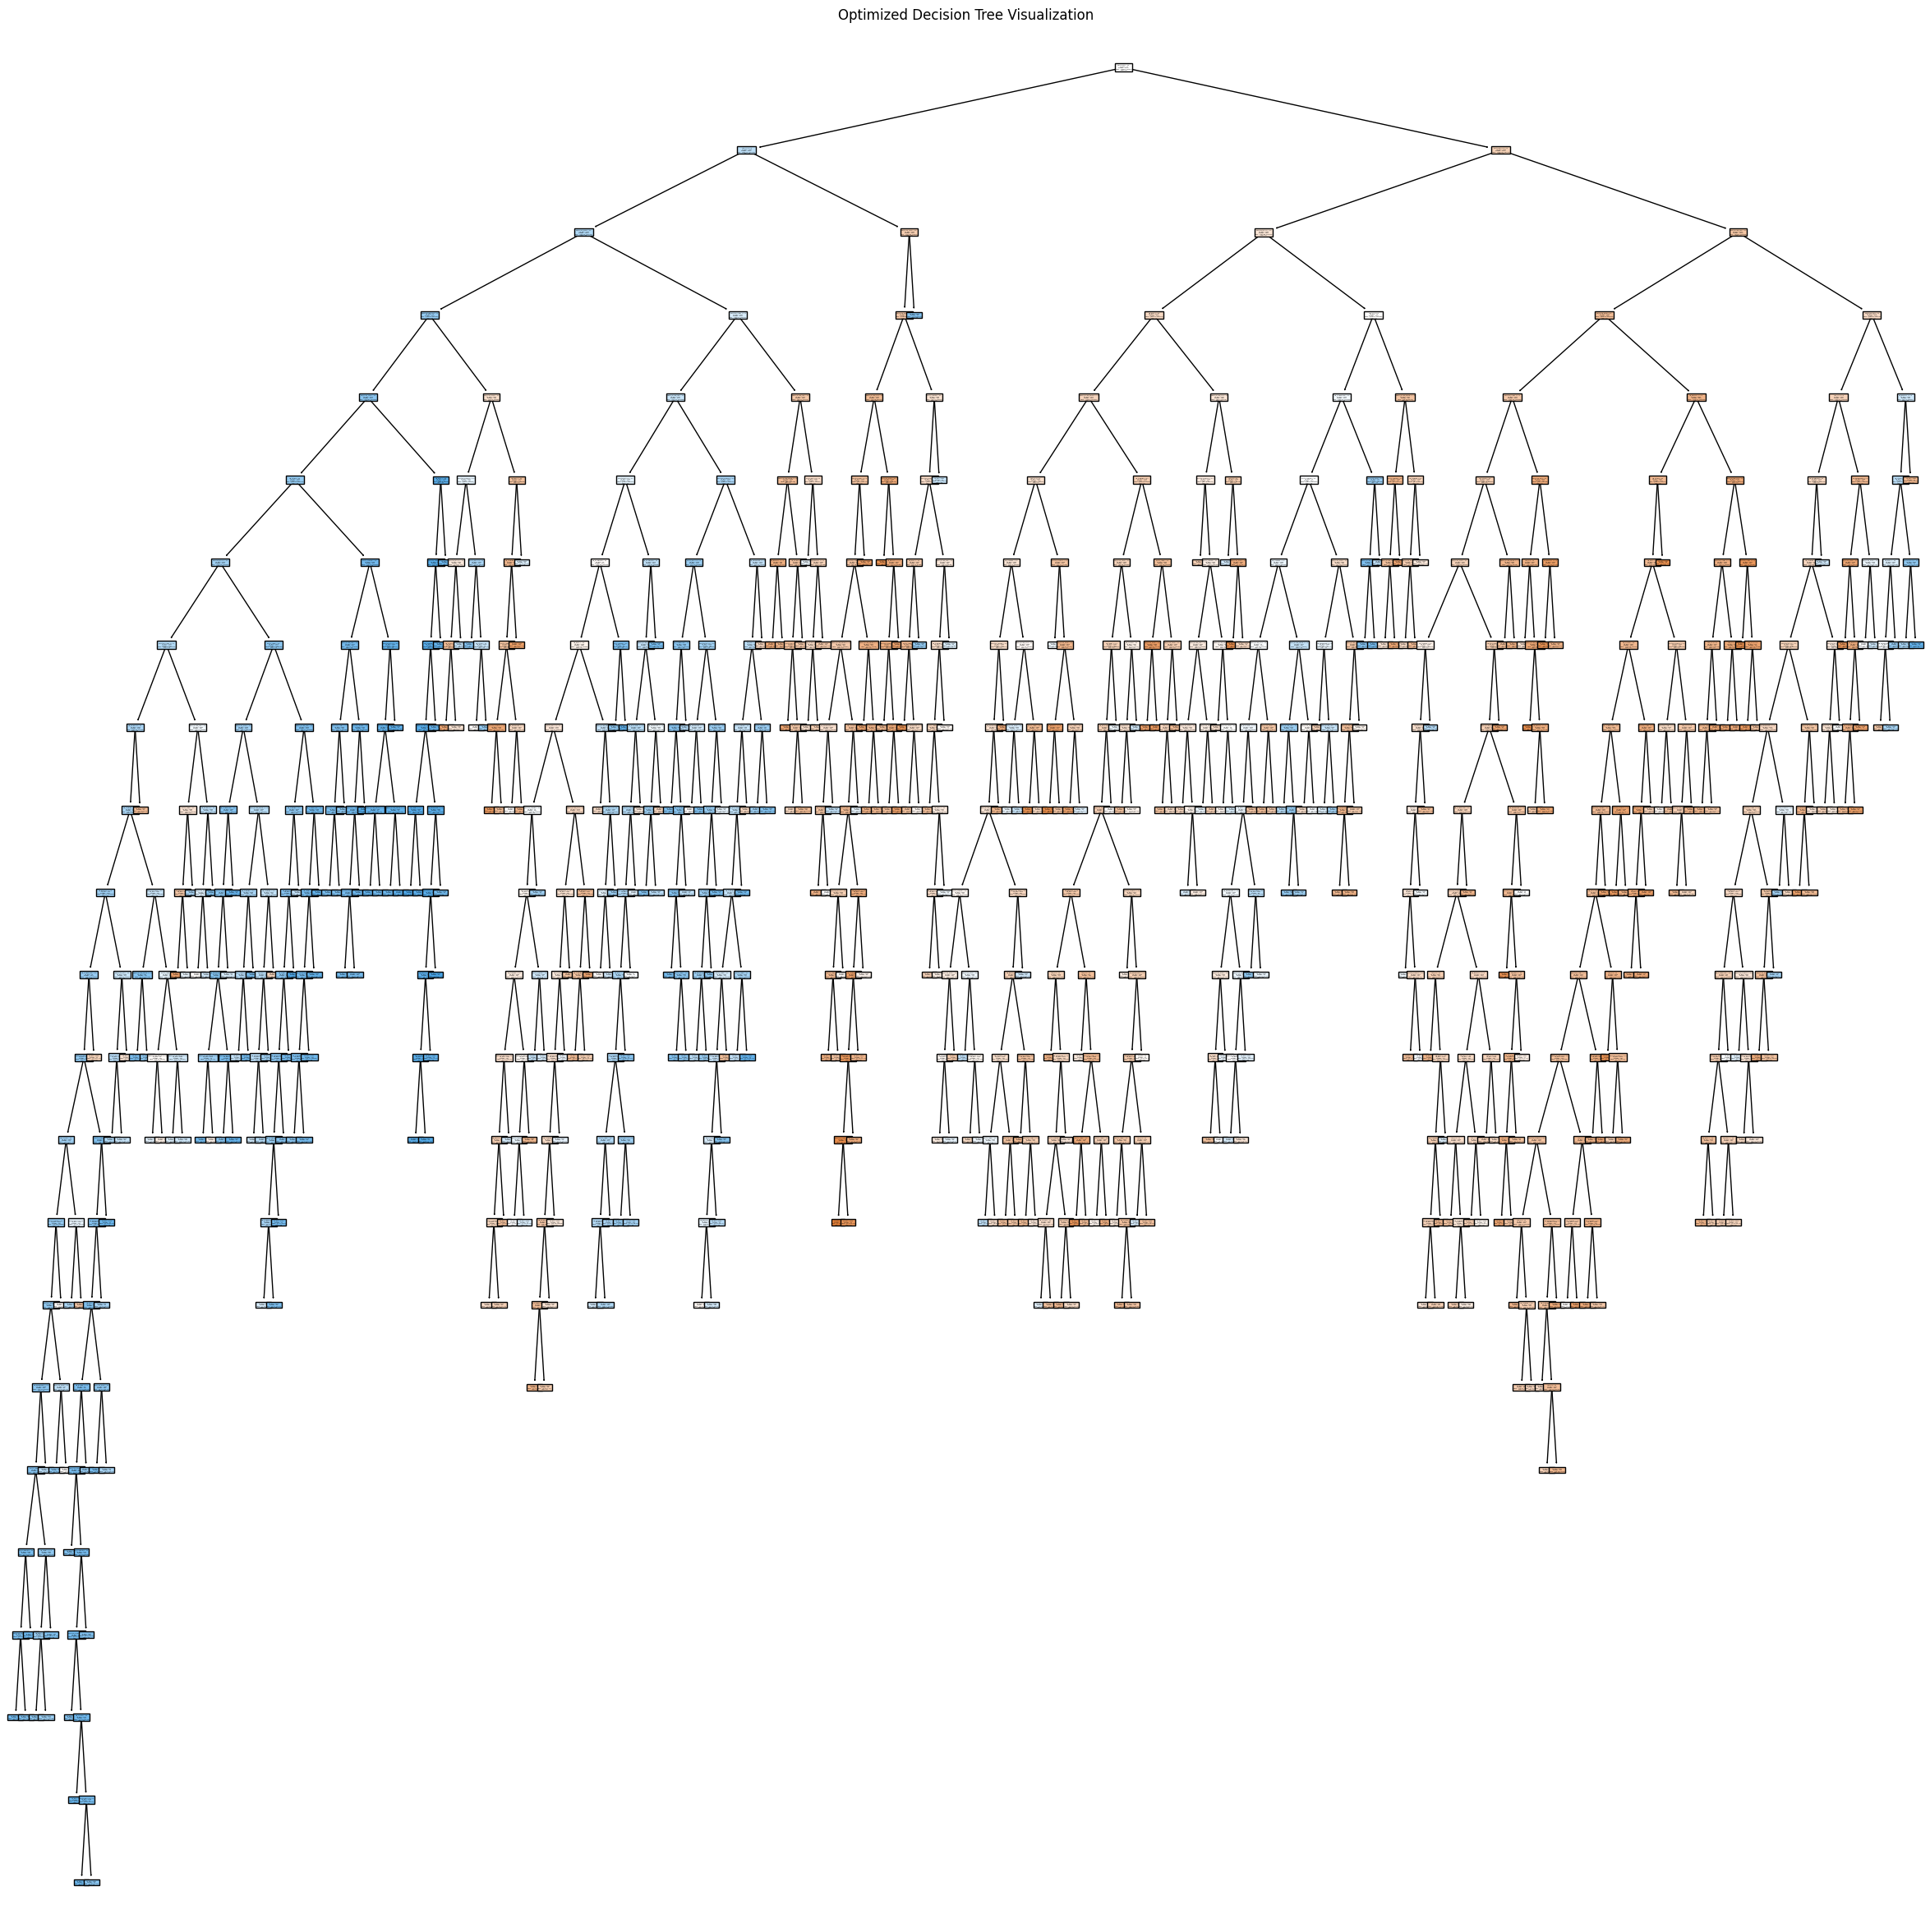

In [ ]:
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
plot_tree(decision_tree, filled=True, feature_names=X_3_train.columns, class_names=['No', 'Yes'])
plt.title("Optimized Decision Tree Visualization")
plt.savefig('tree_high_res.png', format='png', dpi=5000)  # Save as high-resolution PNG

